In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import time
import re

plt.style.use('ggplot')
tqdm.pandas()
seed = 101

Load data.

In [2]:
comments = pd.read_csv('../data/toxicity_annotated_comments.tsv', sep='\t')
comments.head()

,rev_id,comment,year,logged_in,ns,sample,split
0,2232.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train
1,4216.0,`NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...,2002,True,user,random,train
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test
3,26547.0,`This is such a fun entry. DevotchkaNEWLINE_...,2002,True,article,random,train
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test


In [3]:
comments.shape

(159686, 7)

In [4]:
annotations = pd.read_csv('../data/toxicity_annotations.tsv', sep='\t')
annotations.head()

,rev_id,worker_id,toxicity,toxicity_score
0,2232.0,723,0,0.0
1,2232.0,4000,0,0.0
2,2232.0,3989,0,1.0
3,2232.0,3341,0,0.0
4,2232.0,1574,0,1.0


In [5]:
annotations.shape

(1598289, 4)

Let's start by fixing some escaped characters: newline, tab, and quote (").

In [6]:
def fix_characters(text):
    text = re.sub(r'NEWLINE_TOKEN', '\n', text)
    text = re.sub(r'TAB_TOKEN', '\t', text)
    text = re.sub(r'`', '"', text)
    return text

comments['comment'] = comments['comment'].progress_map(fix_characters)
comments.head()

  0%|          | 0/159686 [00:00<?, ?it/s]

,rev_id,comment,year,logged_in,ns,sample,split
0,2232.0,This:\n:One can make an analogy in mathematica...,2002,True,article,random,train
1,4216.0,"""\n\n:Clarification for you (and Zundark's ri...",2002,True,user,random,train
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test
3,26547.0,"""This is such a fun entry. Devotchka\n\nI on...",2002,True,article,random,train
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test


Now that we have "clean" dataset, let's look at the distribution of comments and see if we see anything interesting.

  0%|          | 0/159686 [00:00<?, ?it/s]

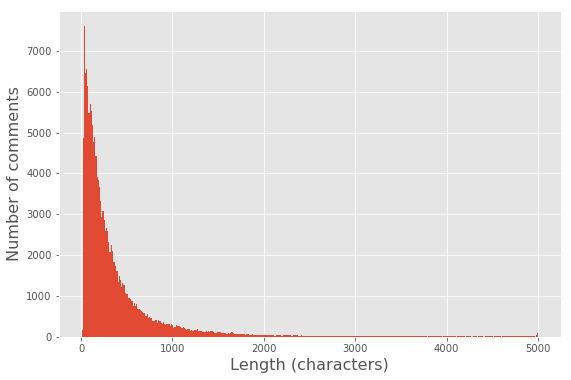

In [7]:
lengths = comments['comment'].progress_map(len)

plt.figure(figsize=(9,6))
plt.hist(lengths, bins='fd')
plt.xlabel('Length (characters)', fontsize=16)
plt.ylabel('Number of comments', fontsize=16)
plt.show()

Do we have any duplicate comments? If so, what do they look like?

In [8]:
unique_comments = comments.groupby('comment', as_index=False)['rev_id'].count() # Method chaining!
unique_comments[unique_comments['rev_id'] > 1].sort_values('rev_id', ascending=False).head()

,comment,rev_id
127769,"""\n==The Graceful Slick....==\nIs non other th...",8
136913,"""Thank you for experimenting with Wikipedia. ...",7
128433,"""\nWelcome\n\nHello and welcome to Wikipedia! ...",6
136915,"""Thank you for experimenting with Wikipedia. ...",6
152360,Thank you for experimenting with Wikipedia. Y...,5


In [9]:
print(unique_comments.loc[127769, 'comment'])

"
==The Graceful Slick....==
Is non other than an ungraceful dick!  "


In [10]:
print(unique_comments.loc[136913, 'comment'])

"Thank you for experimenting with  Wikipedia. Your test worked, and it has been reverted or removed. Please use the sandbox for any other tests you may want to do. Take a look at the welcome page to learn more about contributing to our encyclopedia.   "


Looks like there are some boilerplate messages. We may want to drop duplicates, but let's look at getting labels before we consider that. Each comment has multiple annotations, where the annotator has assigned a score. The score is based on a survey shown in the docs folder. The questions are as follows:

- **Very toxic** (a very hateful, aggressive, or disrespectful comment that is very likely to make you leave a discussion)
- **Toxic** (a rude, disrespectiful, or unreasonable comment that is somehwat likely to make you leave a discussion)
- **Neither**
- **Healthy contribution** (a reasonable, civil, or polite contribution that is somewhat likely to make you want to continue a discussion)
- **Very healthly contribution** (a very polite, throughful, or helpful contribution that is very likely to make you want to continue a discussion)

From top to bottom, the scores are -2, -1, 0, 1, and 2. We need to find a way to aggregate the toxicity_scores assigned to each comment. Also, what is the distribution of annotations over rev_id?

In [11]:
annotations.groupby('rev_id')['toxicity_score'].count().value_counts() # Method chaining!

10    153852
9       2541
11      2062
8        626
12       308
20       223
13        59
19         9
21         4
18         1
14         1
Name: toxicity_score, dtype: int64

In [12]:
def agg_toxicity_scores(sub):
    result = {}
    result['num'] = sub.shape[0]
    result['min'] = sub['toxicity_score'].min()
    result['max'] = sub['toxicity_score'].max()
    result['avg'] = sub['toxicity_score'].mean()
    return pd.Series(result)

scores = annotations.groupby('rev_id').progress_apply(agg_toxicity_scores).reset_index()
scores.head()

  0%|          | 0/159686 [00:00<?, ?it/s]

,rev_id,num,min,max,avg
0,2232.0,10.0,-1.0,1.0,0.4
1,4216.0,10.0,0.0,2.0,0.5
2,8953.0,10.0,0.0,1.0,0.1
3,26547.0,10.0,0.0,2.0,0.6
4,28959.0,10.0,-1.0,1.0,0.2


Now we can merge back into the comments dataframe.

In [13]:
df = pd.merge(comments, scores, on='rev_id')
df.head()

,rev_id,comment,year,logged_in,ns,sample,split,num,min,max,avg
0,2232.0,This:\n:One can make an analogy in mathematica...,2002,True,article,random,train,10.0,-1.0,1.0,0.4
1,4216.0,"""\n\n:Clarification for you (and Zundark's ri...",2002,True,user,random,train,10.0,0.0,2.0,0.5
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test,10.0,0.0,1.0,0.1
3,26547.0,"""This is such a fun entry. Devotchka\n\nI on...",2002,True,article,random,train,10.0,0.0,2.0,0.6
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test,10.0,-1.0,1.0,0.2


Before we go much further, let's take a look at some of the "toxic" comments. In theory, those with a max toxicity score of -2.0 should be the worst. Is that true?

In [14]:
idx = df['max'] == -2.0
df.loc[idx, 'comment'].sample(10, random_state=seed)

40815    YOU SUCK YOU SUCK YOU SUCK YOU SUCK YOU SUCK Y...
90280    FUCKING BITCHES THAT ARE READING THIS. JASENM2...
90685    NJGW IS AN UNEMPLOYED MOTHER FUCKING BASTARD L...
59017    \n\n== jerk me jolly ==\n\nfuckfuckfuckfuckfuc...
29133    \n\nFUCKING COCKSUCKING ADMINS, EAT MY SHIT CU...
98873    \n\n\n==You Cunt ==\nGo fuck yourself you piec...
51127    \n\n\nFUCK OFFFUCK OFFFUCK OFFFUCK OFFFUCK OFF...
76810    \n\n==Fuck You==\n\nGo suck on a fat dick fagg...
81942    SUCK MY COCK D SUCK MY COCK D SUCK MY COCK D S...
79522    YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A...
Name: comment, dtype: object

Yup. All terrible. What about the other end? In theory, those with a min toxicity score of 2.0 should be the best. Is that true?

In [15]:
idx = df['min'] == 2.0
idx.sum()

0

Ironically, _nobody_ has a min toxicity score equal to 2.0. I guess the bar is just higher for good content. Let's look at the distribution of the mean toxicity score and try to find a few with high marks.

In [16]:
df['avg'].quantile([0.9, 0.95, 0.99])

0.90    0.7
0.95    0.8
0.99    1.0
Name: avg, dtype: float64

In [17]:
idx = df['avg'] >= 1.0
df.loc[idx, 'comment'].sample(10, random_state=seed)

68722     "\n::We might want to consider redirecting it ...
143203    "\n:sorry for reverting you! I did not mean to...
152634    "\n\n== Please correct two of the contribution...
136008    \n\n* DDD. Thank you  for your time and effort...
81762                 Thanks for fixing the problem.   \n\n
155267    \n\n==Hi==\nHey Ebyabe... Look listen... I'm s...
26909     \ni am sorry for any trouble i have caused. My...
89714     \n:Civility please. That link is the place whe...
113806    \n::::That's good by me then, Gabriel. Thanks ...
8590      Welcome!\n\nHello , and welcome to Wikipedia! ...
Name: comment, dtype: object

In [18]:
print(df.loc[68722, 'comment'])

"
::We might want to consider redirecting it to Health applications and clinical studies of meditation. ""Meditation therapy"" seems to be an uncommon term in clinical applications and doesn't, in my mind, deserve an article. I'm somewhat familiar with research on health applications of mediation, and I've never seen that term used. If you do a search on that term in the Pubmed medical index, it only brings up 3 results, and none is an empirical study but are instead generalized discussions. By contrast, a search on the term ""Transcendental Meditation"" brings up 262 studies, and ""mindfulness meditation"" brings up 81 studies.   "


In [19]:
print(df.loc[89714, 'comment'])


:Civility please. That link is the place where you uploaded the image on Wikipedia. Please provide the source of where you downloaded the image from. Thanks   


Interesting. At least a few of these comments are an appeal for civility. Now that we have a better understanding of what constitutes the two classes, we need to make a decision about our target. A safe bet is to group everything with a mean score equal to or above 0.0 as a non-toxic message.

In [20]:
df['y'] = df['avg'].progress_map(lambda x: int(x < 0))
df.head()

  0%|          | 0/159686 [00:00<?, ?it/s]

,rev_id,comment,year,logged_in,ns,sample,split,num,min,max,avg,y
0,2232.0,This:\n:One can make an analogy in mathematica...,2002,True,article,random,train,10.0,-1.0,1.0,0.4,0
1,4216.0,"""\n\n:Clarification for you (and Zundark's ri...",2002,True,user,random,train,10.0,0.0,2.0,0.5,0
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test,10.0,0.0,1.0,0.1,0
3,26547.0,"""This is such a fun entry. Devotchka\n\nI on...",2002,True,article,random,train,10.0,0.0,2.0,0.6,0
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test,10.0,-1.0,1.0,0.2,0


In [21]:
df['y'].value_counts(normalize=True)

0    0.815532
1    0.184468
Name: y, dtype: float64

In [22]:
df.groupby('split').aggregate({'y':np.mean})

,y
split,
dev,0.182956
test,0.181698
train,0.185899


Roughly 18.5% of all comments are toxic (and that fraction holds across all splits). Now that we have labels, let's revisit the comments. First, we need to break up the text into tokens. Let's start by grabbing all alpha tokens. How many unique tokens are in the comments?

In [23]:
def alpha_tokenize(text):
    return re.findall(r'[a-zA-Z]+', text)

alpha_tokenize(df.loc[89714, 'comment'])

['Civility',
 'please',
 'That',
 'link',
 'is',
 'the',
 'place',
 'where',
 'you',
 'uploaded',
 'the',
 'image',
 'on',
 'Wikipedia',
 'Please',
 'provide',
 'the',
 'source',
 'of',
 'where',
 'you',
 'downloaded',
 'the',
 'image',
 'from',
 'Thanks']

In [24]:
idx_train = df['split'] == 'train'
idx_dev = df['split'] == 'dev'
idx_test = df['split'] == 'test'

In [25]:
token_dict = {}
for comment in tqdm(df.loc[idx_train, 'comment']):
    tokens = alpha_tokenize(comment)
    for token in tokens:
        if token in token_dict:
            token_dict[token] += 1
        else:
            token_dict[token] = 1

len(token_dict)

  0%|          | 0/95692 [00:00<?, ?it/s]

157978

We can examine the token_dict object directly, to see what the structure looks like.

In [26]:
list(token_dict.items())[:10]

[('This', 10113),
 ('One', 1343),
 ('can', 21713),
 ('make', 7548),
 ('an', 25972),
 ('analogy', 91),
 ('in', 81315),
 ('mathematical', 116),
 ('terms', 1065),
 ('by', 23959)]

We can also look at the distribution of word length in this token set.

In [27]:
lengths = [len(token) for token in token_dict.keys()]
np.percentile(lengths, [50, 90, 95])

array([ 7., 11., 13.])

Let's look at some tokens that only show up once.

In [28]:
one_hit_wonders = [token for token, count in token_dict.items() if count == 1]
rng = np.random.RandomState(seed)
for i in rng.randint(0, len(one_hit_wonders)+1, 20):
    print(one_hit_wonders[i])

LEITMOTIV
garish
Wessonsuoum
Manduca
Ioannis
eSearchServer
AynRand
DengXiaoPing
HIPAA
HAAHA
Maathai
TheUnbelieveableTruth
Zapecptyltd
Ttiotsw
gymnasts
eOoFAAAAIBAJ
distiller
accidentaly
willpower
Gidon


That is a _lot_ of features. What happens if we allow alphanumeric tokens?

In [29]:
def alphanumeric_tokenize(text):
    return re.findall(r'[a-zA-Z0-9]+', text)

token_dict = {}
for comment in tqdm(df.loc[idx_train, 'comment']):
    tokens = alphanumeric_tokenize(comment)
    for token in tokens:
        if token in token_dict:
            token_dict[token] += 1
        else:
            token_dict[token] = 1

len(token_dict)

  0%|          | 0/95692 [00:00<?, ?it/s]

166277

It actually doesn't blow things up too much (this is very domain-specific). What do those alphanumeric tokens look like?

In [30]:
numeric_tokens = []
for token in tqdm(token_dict.keys()):
    if np.any([c.isnumeric() for c in token]):
        numeric_tokens.append(token)

  0%|          | 0/166277 [00:00<?, ?it/s]

In [31]:
rng = np.random.RandomState(seed)
for i in rng.randint(0, len(numeric_tokens)+1, 20):
    print(numeric_tokens[i])

9am
McFly85
b1
Z500
237
1253471852
P3P
misc2
H1N1
age2
10s
app1
TV2
or3
archive5
101202
01929
P56
1899
451b


It's not clear that we would need these tokens, and the truth is that numeric tokens can quickly blow up your feature space. Let's exclude them and try to reduce the overall number of tokens by casting everything to lowercase.

In [32]:
def alpha_lower_tokenize(text):
    return re.findall(r'[a-z0-9]+', text.lower())

alpha_lower_tokenize(df.loc[89714, 'comment'])

['civility',
 'please',
 'that',
 'link',
 'is',
 'the',
 'place',
 'where',
 'you',
 'uploaded',
 'the',
 'image',
 'on',
 'wikipedia',
 'please',
 'provide',
 'the',
 'source',
 'of',
 'where',
 'you',
 'downloaded',
 'the',
 'image',
 'from',
 'thanks']

In [33]:
token_dict = {}
for comment in tqdm(df.loc[idx_train, 'comment']):
    tokens = alpha_lower_tokenize(comment)
    for token in tokens:
        if token in token_dict:
            token_dict[token] += 1
        else:
            token_dict[token] = 1

len(token_dict)

  0%|          | 0/95692 [00:00<?, ?it/s]

132883

In [34]:
one_hit_wonders = [token for token, count in token_dict.items() if count == 1]
rng = np.random.RandomState(seed)
for i in rng.randint(0, len(one_hit_wonders)+1, 20):
    print(one_hit_wonders[i])

treatening
aljazeerah
ghaddar
ltl
anexpert
balija
copyied
pitting
glenna
contraband
lutch
kangaroos
bhattara
cabiai
centimetres
mcw
wau
complte
arduino
yapped


Now let's consider some n-grams, or contiguous sequences of n-items. These can be powerful indicators, since individual words may not carry the same meaning as a phrase (e.g., Air Canada). This functionality (and much of what we have already done) is built into scikit-learn, but let's code something from python primatives to show what's going on behind the scenes.

In [35]:
def get_ngrams(tokens, n=2):
    ngrams = zip(*[tokens[i:] for i in range(n)])
    ngrams = [' '.join(ngram) for ngram in ngrams]
    return ngrams

In [36]:
df.loc[89714, 'comment']

'\n:Civility please. That link is the place where you uploaded the image on Wikipedia. Please provide the source of where you downloaded the image from. Thanks   '

In [37]:
tokens = alpha_lower_tokenize(df.loc[89714, 'comment'])
tokens

['civility',
 'please',
 'that',
 'link',
 'is',
 'the',
 'place',
 'where',
 'you',
 'uploaded',
 'the',
 'image',
 'on',
 'wikipedia',
 'please',
 'provide',
 'the',
 'source',
 'of',
 'where',
 'you',
 'downloaded',
 'the',
 'image',
 'from',
 'thanks']

In [38]:
get_ngrams(tokens, n=2)

['civility please',
 'please that',
 'that link',
 'link is',
 'is the',
 'the place',
 'place where',
 'where you',
 'you uploaded',
 'uploaded the',
 'the image',
 'image on',
 'on wikipedia',
 'wikipedia please',
 'please provide',
 'provide the',
 'the source',
 'source of',
 'of where',
 'where you',
 'you downloaded',
 'downloaded the',
 'the image',
 'image from',
 'from thanks']

In [39]:
get_ngrams(tokens, n=3)

['civility please that',
 'please that link',
 'that link is',
 'link is the',
 'is the place',
 'the place where',
 'place where you',
 'where you uploaded',
 'you uploaded the',
 'uploaded the image',
 'the image on',
 'image on wikipedia',
 'on wikipedia please',
 'wikipedia please provide',
 'please provide the',
 'provide the source',
 'the source of',
 'source of where',
 'of where you',
 'where you downloaded',
 'you downloaded the',
 'downloaded the image',
 'the image from',
 'image from thanks']

We can then simply loop over the range of n-grams we would like to consider.

In [40]:
def ngram_alpha_lower_tokenize(text, ngram_range=(1,1)):
    tokens = re.findall(r'[a-z]+', text.lower())
    ngrams = []
    for n in range(ngram_range[0], ngram_range[1]+1):
        ngrams += get_ngrams(tokens, n)
    return ngrams

test = '''This is a test sentence.'''
tokens = ngram_alpha_lower_tokenize(test, (1,3))
tokens

['this',
 'is',
 'a',
 'test',
 'sentence',
 'this is',
 'is a',
 'a test',
 'test sentence',
 'this is a',
 'is a test',
 'a test sentence']

Let's start with unigrams and bigrams. How large will the feature set get?

In [41]:
token_dict = {}
for comment in tqdm(df.loc[idx_train, 'comment']):
    tokens = ngram_alpha_lower_tokenize(comment, ngram_range=(1,2))
    for token in tokens:
        if token in token_dict:
            token_dict[token] += 1
        else:
            token_dict[token] = 1

len(token_dict)

  0%|          | 0/95692 [00:00<?, ?it/s]

1573784

Adding bigrams led to a 10X increase in features! What do some of these bigrams look like?

In [42]:
bigrams = [token for token in tqdm(token_dict.keys()) if len(token.split(' ')) > 1]
rng = np.random.RandomState(seed)
for i in rng.randint(0, len(bigrams)+1, size=20):
    print(bigrams[i])

  0%|          | 0/1573784 [00:00<?, ?it/s]

brightest one
stresses it
classification has
compliance which
sexualities disapproved
your oppinion
photos have
completely private
glaring omissions
company freaking
civility funny
to peace
johnkocis and
jokes they
even me
count needs
easily mended
many occasuons
i paraded
ll scroll


What percentage of these bigrams are one-off?

In [43]:
bigram_counts = [token_dict[bigram] for bigram in tqdm(bigrams)]
pd.value_counts(bigram_counts, normalize=True).head()

  0%|          | 0/1449323 [00:00<?, ?it/s]

1    0.712502
2    0.122628
3    0.047503
4    0.025922
5    0.015860
dtype: float64

Clearly, a ton of these will need to be removed. What happens if we add trigrams?

In [44]:
token_dict = {}
for comment in tqdm(df.loc[idx_train, 'comment']):
    tokens = ngram_alpha_lower_tokenize(comment, ngram_range=(1,3))
    for token in tokens:
        if token in token_dict:
            token_dict[token] += 1
        else:
            token_dict[token] = 1

len(token_dict)

  0%|          | 0/95692 [00:00<?, ?it/s]

5125033

Wow, 5.1 million unigrams, bigrams, and trigrams. Let's look at a few of them.

In [45]:
trigrams = [token for token in tqdm(token_dict.keys()) if len(token.split(' ')) == 3]
rng = np.random.RandomState(seed)
for i in rng.randint(0, len(trigrams)+1, size=20):
    print(trigrams[i])

  0%|          | 0/5125033 [00:00<?, ?it/s]

even wait until
not in french
off of other
very simple find
stuffed after being
why a photo
reliable ref names
hello i too
even phrases like
hulk hogan jerry
ago is it
care for the
staple starch for
fire up google
and f c
the help at
savior jason giambi
black lantern laurie
codespeak for we
argued that they


Okay, so clearly we need some method of choosing which features to keep. Let's make a small modification to the token counts so that we can look at _document frequency_. We'll start with unigrams and bigrams.

In [46]:
df_token_dict = {}
for comment in tqdm(df.loc[idx_train, 'comment']):
    tokens = ngram_alpha_lower_tokenize(comment, (1,2))
    for token in set(tokens):
        if token in df_token_dict:
            df_token_dict[token] += 1
        else:
            df_token_dict[token] = 1

len(df_token_dict)

  0%|          | 0/95692 [00:00<?, ?it/s]

1573784

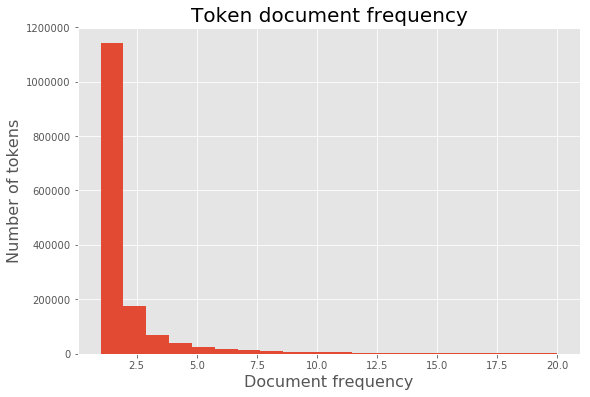

In [47]:
dfs = list(df_token_dict.values())

plt.figure(figsize=(9,6))
plt.hist(dfs, bins=20, range=(1,20))
plt.title('Token document frequency', fontsize=20)
plt.xlabel('Document frequency', fontsize=16)
plt.ylabel('Number of tokens', fontsize=16)
plt.show()

In [48]:
pd.value_counts(dfs, normalize=True).head()

1    0.725145
2    0.110817
3    0.044647
4    0.024533
5    0.015420
dtype: float64

Threshold is obviously going to have a large effect on the total vocabulary. Is throwing out low-frequency terms going to affect the model performance? Let's look at the distribution of token lengths.

In [49]:
tokens = list(df_token_dict.keys())
token_len = np.array([len(token) for token in tokens])
token_len

array([14,  6, 13, ..., 20, 17, 10])

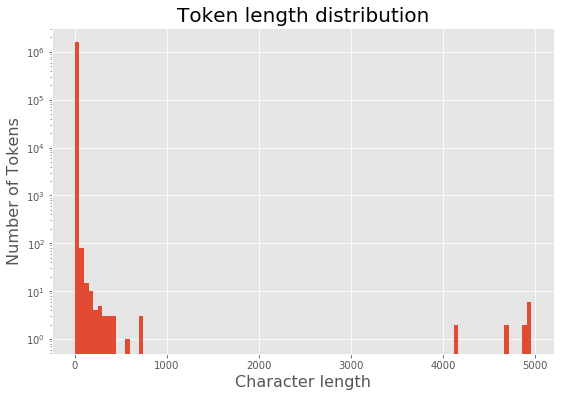

In [50]:
plt.figure(figsize=(9,6))
plt.hist(token_len, bins=100)
plt.title('Token length distribution', fontsize=20)
plt.xlabel('Character length', fontsize=16)
plt.ylabel('Number of Tokens', fontsize=16)
plt.yscale('log')
plt.show()

Strange that there are some _very_ long tokens. What do they look like?

In [51]:
for token in tokens:
    if len(token) > 4000:
        print(token)

banned crapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapc

I'm guessing these tokens don't contribute much to discussions, and they don't show up often enough to be statistically meaningful. One strategy is to consider breaking tokens into character n-grams, which would certainly help to isolate some of the repeated four-letter words above.

In [52]:
def get_char_ngrams(token, n=2):
    char_ngrams = zip(*[token[i:] for i in range(n)])
    char_ngrams = [''.join(char_ngram) for char_ngram in char_ngrams]
    return char_ngrams

def ngram_alpha_char_tokenize(text, char_ngram_range=(1,1)):
    tokens = re.findall(r'[a-z]+', text.lower())
    char_ngrams = []
    for token in tokens:
        for n in range(char_ngram_range[0], char_ngram_range[1]+1):
            char_ngrams += get_char_ngrams(token, n)
    return char_ngrams

test = 'this is a sentence about a banana'
ngram_alpha_char_tokenize(test, char_ngram_range=(2,3))

['th',
 'hi',
 'is',
 'thi',
 'his',
 'is',
 'se',
 'en',
 'nt',
 'te',
 'en',
 'nc',
 'ce',
 'sen',
 'ent',
 'nte',
 'ten',
 'enc',
 'nce',
 'ab',
 'bo',
 'ou',
 'ut',
 'abo',
 'bou',
 'out',
 'ba',
 'an',
 'na',
 'an',
 'na',
 'ban',
 'ana',
 'nan',
 'ana']

What does the feature space look like for these character ngrams? Let's start with 2 and 3 grams (likely, we'd see unigrams across all comments).

In [53]:
df_token_dict = {}
for comment in tqdm(df.loc[idx_train, 'comment']):
    tokens = ngram_alpha_char_tokenize(comment, (2,3))
    for token in set(tokens):
        if token in df_token_dict:
            df_token_dict[token] += 1
        else:
            df_token_dict[token] = 1

len(df_token_dict)

  0%|          | 0/95692 [00:00<?, ?it/s]

13560

The feature space is really pretty small. What's the distribution look like?

In [54]:
dfs = list(df_token_dict.values())
pd.value_counts(dfs, normalize=True).head()

1    0.168658
2    0.086947
3    0.057670
4    0.042478
5    0.032153
dtype: float64

Much flatter. Let's expand the char_ngram range out to 11, which is 90th percentile from our previous unigram token dictionary.

In [55]:
df_token_dict = {}
for comment in tqdm(df.loc[idx_train, 'comment']):
    tokens = ngram_alpha_char_tokenize(comment, (2,11))
    for token in set(tokens):
        if token in df_token_dict:
            df_token_dict[token] += 1
        else:
            df_token_dict[token] = 1

len(df_token_dict)

  0%|          | 0/95692 [00:00<?, ?it/s]

957420

In [56]:
dfs = list(df_token_dict.values())
pd.value_counts(dfs, normalize=True).head()

1    0.582453
2    0.120411
3    0.057049
4    0.033299
5    0.023298
dtype: float64

In [57]:
char_tokens = [k for k in df_token_dict.keys() if len(k) >= 7]
rng = np.random.RandomState(seed)
for i in rng.randint(0, len(char_tokens)+1, size=20):
    print(char_tokens[i])

neffabi
riolanus
iliatingly
xtremit
antonian
restlez
oundzero
enotheist
essdange
truthjusti
overdocto
ostulated
ofmidni
xperiments
eybombi
evilavata
olonelhe
fresnocopti
riiodothy
atospheric


Interesting, the feature space is large, but no where near as large as the unigrams + bigrams + trigrams vocabulary. The truth is that all this exploration is useful, but the best indicator of feature importance is downstream performance. Before we go, let's dump the dataframe into a sqlite database so we don't have to reprocess everything.

In [58]:
import sqlite3 as sql
import os

if not os.path.isfile('../data/toxic.db'):
    with sql.connect('../data/toxic.db') as conn:
        df.to_sql('toxic', conn, index=False)